In [ ]:
from zipfile import ZipFile 
  
# loading the temp.zip and creating a zip object 
with ZipFile("fashion/FashionGen/images_val.zip", 'r') as zObject: 
  
    # Extracting all the members of the zip  
    # into a specific location. 
    zObject.extractall( 
        path="fashion/FashionGen") 

In [ ]:
import os

def count_files_in_directory(directory):
    try:
        # Lấy danh sách các file và thư mục con trong thư mục
        files_and_dirs = os.listdir(directory)

        # Đếm số file trong danh sách (loại trừ thư mục)
        num_files = sum(os.path.isfile(os.path.join(directory, item)) for item in files_and_dirs)

        return num_files
    except Exception as e:
        print(f"An error occurred: {e}")
        return 0

# Sử dụng hàm
directory_path = 'fashion/FashionGen/images_val'  # Thay thế bằng đường dẫn thực tế
print(f"Number of files in '{directory_path}': {count_files_in_directory(directory_path)}")


In [ ]:
pip install matplotlib scikit-learn transformers evaluate rouge_score

In [ ]:
pip install accelerate>=0.21.0

# **Import Libraries**

In [1]:
import os
import datasets
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm
import multiprocessing as mp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
#from nltk.translate.bleu_score import corpus_bleu
from torchvision import transforms
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import io, transforms
from torch.utils.data import Dataset, DataLoader, random_split
import json
import pandas as pd
from transformers import Seq2SeqTrainer ,Seq2SeqTrainingArguments
from transformers import VisionEncoderDecoderModel , ViTFeatureExtractor
from transformers import AutoTokenizer ,  GPT2Config , default_data_collator
import warnings
warnings.filterwarnings("ignore")

# **GPU Testing**

In [2]:
if torch.cuda.is_available():    

    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA RTX A5000


# **Defining Hyperparameters**

In [3]:
os.environ["WANDB_DISABLED"] = "true"
class config : 
    ENCODER = "microsoft/beit-base-patch16-224-pt22k-ft22k"
    DECODER = "gpt2"
    TRAIN_BATCH_SIZE = 8
    VAL_BATCH_SIZE = 8
    VAL_EPOCHS = 1
    LR = 5e-5
    SEED = 42
    MAX_LEN = 128
    SUMMARY_LEN = 20
    WEIGHT_DECAY = 0.01
    MEAN = (0.485, 0.456, 0.406)
    STD = (0.229, 0.224, 0.225)
    TRAIN_PCT = 0.95
    NUM_WORKERS = mp.cpu_count()
    EPOCHS = 5
    IMG_SIZE = (224,224)
    LABEL_MASK = -100
    TOP_K = 1000
    TOP_P = 0.95

In [4]:
from transformers import VisionEncoderDecoderModel, AutoTokenizer, AutoModel, AutoModelForCausalLM

model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(config.ENCODER, config.DECODER)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
model.to(device)

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.10.crossattention.c_proj.weight', 'h.10.crossattention.q_attn.bias', 'h.10.crossattention.q_attn.weight', 'h.10.ln_cross_attn.bias', 'h.10.ln_cross_attn.weight', 'h.11.crossattention.c_attn.bias', 'h.11.crossattention.c_attn.weight', 'h.11.crossat

VisionEncoderDecoderModel(
  (encoder): BeitModel(
    (embeddings): BeitEmbeddings(
      (patch_embeddings): BeitPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): BeitEncoder(
      (layer): ModuleList(
        (0): BeitLayer(
          (attention): BeitAttention(
            (attention): BeitSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (relative_position_bias): BeitRelativePositionBias()
            )
            (output): BeitSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (i

# **Tokenizer**

In [5]:
# image feature extractor
from transformers import VisionEncoderDecoderModel, AutoTokenizer, AutoFeatureExtractor
feature_extractor = AutoFeatureExtractor.from_pretrained(config.ENCODER)
# text tokenizer
tokenizer = AutoTokenizer.from_pretrained(config.DECODER)

In [6]:
tokenizer.pad_token = tokenizer.eos_token

model.config.eos_token_id = tokenizer.eos_token_id
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.pad_token_id = tokenizer.pad_token_id

# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size
# set beam search parameters
model.config.eos_token_id = tokenizer.sep_token_id

model.config.max_length = 128
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4


In [7]:
model_name = 'beit-gpt-en_v0'

model_dir = f'./models/{model_name}'
model_output_dir = f'{model_dir}/image-captioning-output'
output_dir = f'{model_dir}/beit-gpt-model'

In [8]:
# model.save_pretrained(output_dir)
# feature_extractor.save_pretrained(output_dir)
# tokenizer.save_pretrained(output_dir)

# **Defining Evalution Matrix**

In [ ]:
pip install rouge_score evaluate

In [ ]:
pip install nltk==3.8.1

In [9]:
import nltk
try:
    nltk.data.find("tokenizers/punkt")
except (LookupError, OSError):
    nltk.download("punkt", quiet=True)

In [10]:
import numpy as np
import evaluate
ignore_pad_token_for_loss = True

metric = evaluate.load("rouge")
meteor = evaluate.load('meteor')

def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]

    # rougeLSum expects newline after each sentence
    preds = ["\n".join(nltk.sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(nltk.sent_tokenize(label)) for label in labels]

    return preds, labels

import nltk.translate.bleu_score as bleu

# Thêm hàm tính BLEU scores
def compute_bleu(preds, labels, n):
    bleu_scores = []
    for pred, label in zip(preds, labels):
        pred_tokens = nltk.word_tokenize(pred.lower())
        label_tokens = nltk.word_tokenize(label.lower())
        bleu_score = bleu.sentence_bleu([label_tokens], pred_tokens, weights=[1.0/n]*n)
        bleu_scores.append(bleu_score)
    return bleu_scores


def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    if ignore_pad_token_for_loss:
        # Replace -100 in the labels as we can't decode them.
        labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds,
                                                     decoded_labels)

    # Compute BLEU@1 and BLEU@2
    bleu1_scores = compute_bleu(decoded_preds, decoded_labels, 1)
    bleu2_scores = compute_bleu(decoded_preds, decoded_labels, 2)
    bleu3_scores = compute_bleu(decoded_preds, decoded_labels, 3)
    bleu4_scores = compute_bleu(decoded_preds, decoded_labels, 4)

    # Compute ROUGE scores
    rouge_scores = metric.compute(predictions=decoded_preds,
                                  references=decoded_labels,
                                  use_stemmer=True)
    rouge_scores = {k: round(v * 100, 4) for k, v in rouge_scores.items()}
    
    meteor_scores = meteor.compute(predictions=decoded_preds,
                                  references=decoded_labels,
                                  )

    prediction_lens = [
        np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds
    ]
    gen_len_mean = np.mean(prediction_lens)

    result = {
        "bleu_1": round(np.mean(bleu1_scores) * 100, 4),
        "bleu_2": round(np.mean(bleu2_scores) * 100, 4),
        "bleu_3": round(np.mean(bleu3_scores) * 100, 4),
        "bleu_4": round(np.mean(bleu4_scores) * 100, 4),
        **rouge_scores,
        "meteor": round(meteor_scores['meteor']*100, 4),
        "gen_len": gen_len_mean
    }
    return result


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# **Normalization Of Image**

In [11]:
from torchvision import io, transforms
transforms = transforms.Compose(
    [
        transforms.Resize(config.IMG_SIZE), 
        transforms.ToTensor(),
        transforms.Normalize(
            mean=0.5, 
            std=0.5
        )
   ]
)

# **Loading Dataset**

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Đọc dữ liệu từ file CSV
dtrain = pd.read_csv('fashion/FashionGen/FashionGen.csv')
dval = pd.read_csv('fashion/FashionGen/FashionGen_val.csv')

# # Chia dữ liệu thành tập train và tạm thời là tập còn lại (validation + test)
# dtrain, temp_df = train_test_split(df, test_size=0.2, random_state=42)

# # Chia tiếp tập còn lại thành validation và test
# dval, dtest = train_test_split(temp_df, test_size=0.5, random_state=42)

# # Kiểm tra kích thước của các tập dữ liệu
print("Train set size:", dtrain.shape)
print("Validation set size:", dval.shape)
# print("Test set size:", dtest.shape)


Train set size: (260490, 2)
Validation set size: (32528, 2)


# **Load Image For Training**

In [13]:
from PIL import Image
import torch


class ImageCapatioingDataset(torch.utils.data.Dataset):
    def __init__(self, df,root_dir,max_target_length, transform = None):
        self.df = df
        self.transform = transform
        self.root_dir = root_dir
        self.max_target_length = max_target_length

    def __getitem__(self, idx):
        image = self.df.image.iloc[idx]
        image_path = os.path.join(self.root_dir , image)
        caption = self.df.caption.iloc[idx]
        model_inputs = dict()
        model_inputs['labels'] = self.tokenization_fn(caption, self.max_target_length)
        model_inputs['pixel_values'] = self.feature_extraction_fn(image_path)
        return model_inputs

    def __len__(self):
        return len(self.df)
    
    # text preprocessing step
    def tokenization_fn(self, caption, max_target_length):
        labels = tokenizer(caption, 
                          padding="max_length", 
                          max_length=max_target_length,
                          truncation=True).input_ids

        return labels
    
    # image preprocessing step
    def feature_extraction_fn(self, image_path):
        image = Image.open(image_path).convert('RGB')

        encoder_inputs = feature_extractor(images=image, return_tensors="np")

        return encoder_inputs.pixel_values[0]


train_dataset = ImageCapatioingDataset(dtrain, root_dir = "fashion/FashionGen/images/",max_target_length = 64,transform = transforms)
val_dataset = ImageCapatioingDataset(dval, root_dir = "fashion/FashionGen/images_val/",max_target_length = 64,transform = transforms)
test_dataset = ImageCapatioingDataset(dval, root_dir = "fashion/FashionGen/images_val/",max_target_length = 64,transform = transforms)


# **Model Initialization**

# **Training**

In [16]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    output_dir="./output",
    num_train_epochs=5,
    save_strategy="no",
    logging_dir="./logs",  # Enable logging
)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [17]:
from transformers import Seq2SeqTrainer, default_data_collator

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=default_data_collator,
)

trainer.train()


Epoch,Training Loss,Validation Loss,Bleu 1,Bleu 2,Bleu 3,Bleu 4,Rouge1,Rouge2,Rougel,Rougelsum,Meteor,Gen Len
1,0.671900,0.699561,52.258800,43.018100,35.530600,29.132100,55.739300,34.407800,51.536400,55.121600,53.305100,45.843581
2,0.557200,0.665803,54.480200,45.308800,37.824900,31.418400,57.893900,36.780600,53.625200,57.238900,55.715400,45.745512
3,0.465800,0.670341,55.066400,46.050600,38.650500,32.311000,58.680300,37.714500,54.403600,57.999000,56.275500,45.721225
4,0.399400,0.687328,55.438400,46.326000,38.874900,32.515300,58.934500,37.889000,54.570800,58.234800,56.916400,47.174096
5,0.351100,0.710516,55.697700,46.562300,39.106700,32.765400,59.187000,38.086200,54.726400,58.454600,57.194300,47.389388


TrainOutput(global_step=40705, training_loss=0.5392683172794104, metrics={'train_runtime': 71959.4925, 'train_samples_per_second': 18.1, 'train_steps_per_second': 0.566, 'total_flos': 2.3430732479966085e+20, 'train_loss': 0.5392683172794104, 'epoch': 5.0})

In [20]:
model = VisionEncoderDecoderModel.from_pretrained(model_output_dir)


In [21]:
trainer.train()

Epoch,Training Loss,Validation Loss,Bleu 1,Bleu 2,Bleu 3,Bleu 4,Rouge1,Rouge2,Rougel,Rougelsum,Meteor,Gen Len
1,0.370200,0.714115,54.774900,45.614000,38.161800,31.816500,58.286700,37.081100,53.895600,57.593300,56.369100,47.620635
2,0.293900,0.761381,55.594900,46.196900,38.609900,32.193900,58.655300,37.328900,54.098500,57.906100,57.090900,48.178708
3,0.230500,0.814289,55.407300,46.119000,38.600600,32.222100,58.635000,37.411200,54.110300,57.878500,56.792800,47.601451
4,0.180700,0.852503,55.544100,46.174800,38.613200,32.209700,58.632000,37.337200,54.002400,57.865400,57.113400,48.428585
5,0.146500,0.883582,55.669200,46.314300,38.761800,32.353400,58.811500,37.510800,54.197300,58.034900,57.249800,48.283971


TrainOutput(global_step=40705, training_loss=0.2586590061579007, metrics={'train_runtime': 73978.6439, 'train_samples_per_second': 17.606, 'train_steps_per_second': 0.55, 'total_flos': 2.3430732479966085e+20, 'train_loss': 0.2586590061579007, 'epoch': 5.0})

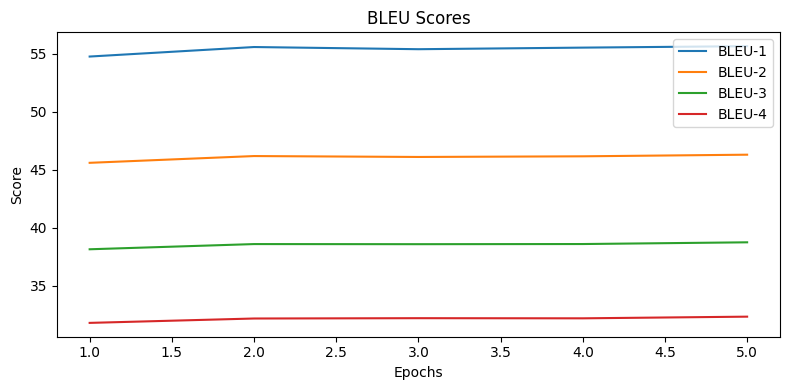

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

log_df = pd.DataFrame(trainer.state.log_history)

# Biểu đồ metric qua các epoch
plt.figure(figsize=(8, 4))
for i in range(1, 5):
    sns.lineplot(data=log_df, x='epoch', y=f'eval_bleu_{i}', label=f'BLEU-{i}')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('BLEU Scores')

plt.tight_layout()
plt.show()


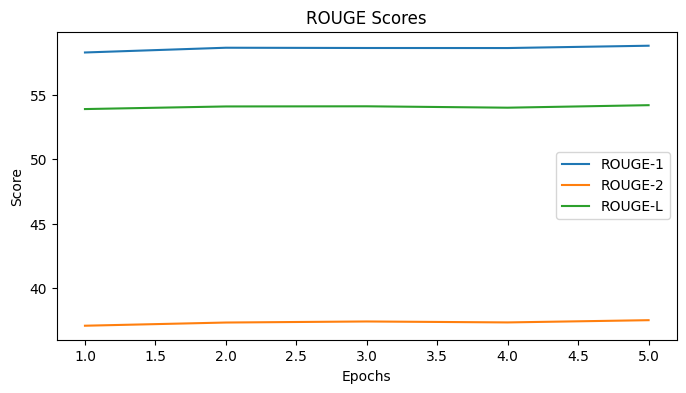

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Chuyển đổi log_history thành DataFrame để dễ xử lý
log_df = pd.DataFrame(trainer.state.log_history)

# Biểu đồ ROUGE score qua các epoch
plt.figure(figsize=(8, 4))

# Vẽ đường cho ROUGE score ROUGE-1, ROUGE-2, ROUGE-L, ROUGE-Lsum
sns.lineplot(data=log_df, x='epoch', y='eval_rouge1', label='ROUGE-1')
sns.lineplot(data=log_df, x='epoch', y='eval_rouge2', label='ROUGE-2')
sns.lineplot(data=log_df, x='epoch', y='eval_rougeL', label='ROUGE-L')

plt.title('ROUGE Scores')
plt.xlabel('Epochs')
plt.ylabel('Score')

plt.show()


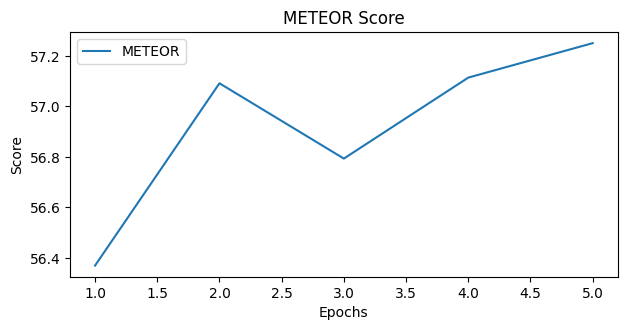

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Chuyển đổi log_history thành DataFrame để dễ xử lý
log_df = pd.DataFrame(trainer.state.log_history)

# Biểu đồ metric qua các epoch
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 4)
sns.lineplot(data=log_df, x='epoch', y='eval_meteor', label='METEOR')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('METEOR Score')

plt.tight_layout()
plt.show()

In [30]:
trainer.evaluate(eval_dataset=test_dataset)

{'eval_loss': 0.8835824728012085,
 'eval_bleu_1': 55.6692,
 'eval_bleu_2': 46.3143,
 'eval_bleu_3': 38.7618,
 'eval_bleu_4': 32.3534,
 'eval_rouge1': 58.8115,
 'eval_rouge2': 37.5108,
 'eval_rougeL': 54.1973,
 'eval_rougeLsum': 58.0349,
 'eval_meteor': 57.2498,
 'eval_gen_len': 48.28397073290704,
 'eval_runtime': 9154.9298,
 'eval_samples_per_second': 3.553,
 'eval_steps_per_second': 0.111,
 'epoch': 5.0}

In [31]:
trainer.save_model(model_output_dir)

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 128, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


In [32]:
tokenizer.save_pretrained(model_output_dir)

('./models/beit-gpt-en_v0/image-captioning-output/tokenizer_config.json',
 './models/beit-gpt-en_v0/image-captioning-output/special_tokens_map.json',
 './models/beit-gpt-en_v0/image-captioning-output/vocab.json',
 './models/beit-gpt-en_v0/image-captioning-output/merges.txt',
 './models/beit-gpt-en_v0/image-captioning-output/added_tokens.json',
 './models/beit-gpt-en_v0/image-captioning-output/tokenizer.json')

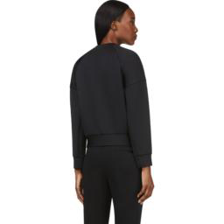

**Actual Caption**: Long sleeve doubled jersey sweatshirt in black. Crewneck collar. Dropped shoulders. Embroidered poodle feature at front in multicolor sequins, beading, and raised, textured thread. Tonal stitching.
**Predicted Caption**: Long sleeve neoprene pullover in grey. Ribbed crewneck collar, sleeve cuffs, and hem. Signature white stitch detail at back yoke. Tonal stitching.


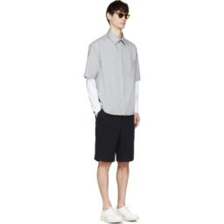

**Actual Caption**: Short sleeve cotton poplin shirt in grey. Spread collar. Zip closure and patch pocket at front. Tonal stitching.
**Predicted Caption**: Relaxed-fit jersey lounge shorts in heather grey. Elasticized waistband. Two-pocket styling. Tonal stitching. Mock fly.


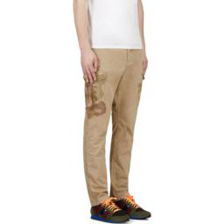

**Actual Caption**: Slim-fit cargo pants in khaki. Seven-pocket styling with tonal leather logo flag at coin pocket. Camouflage patterning at side flap pockets. Light distressing at ankle cuffs. Tonal stitching. Button fly.
**Predicted Caption**: Slim-fit jeans in beige. Five-pocket styling. Logo patch at back hem. Tonal stitching. Zip fly.


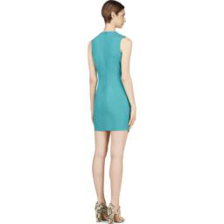

**Actual Caption**: Sleeveless dress in turquoise. Crewneck collar. Invisible zip closure at back. Floating panel at front with signature gold-tone safety pin fastening. Tonal stitching.
**Predicted Caption**: Sleeveless dress in aqua. Crewneck collar. Zip closure at back. Raw edges at armscyes and hem. Unlined. Tonal stitching.


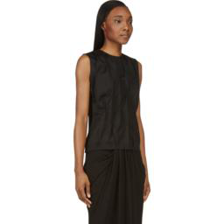

**Actual Caption**: Sleeveless crewneck pick stitched blouse in black. White flocked stitching throughout in gathered diamond honeycomb pattern. Tonal stitching.
**Predicted Caption**: Sleeveless jersey maxi dress in grey. Crewneck collar. Hook-eye closure at nape of neck. Tonal stitching.


In [24]:
import os
import random
import pandas as pd
from PIL import Image
from torchvision.transforms import functional as F
import torch


model = VisionEncoderDecoderModel.from_pretrained(model_output_dir)

tokenizer = AutoTokenizer.from_pretrained(model_output_dir)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

max_length = 64
num_beams = 4
gen_kwargs = {
    "max_length": max_length,
    "num_beams": num_beams,
    # "num_return_sequences": 3,
}



def load_random_image_and_caption(image_dir, captions_file):
    
    captions_df = pd.read_csv(captions_file)
    captions_df = captions_df.iloc[:5000]

    if 'image' not in captions_df.columns:
        print("Column 'image' not found in the CSV file.")
        return None, None


    random_row = captions_df.sample(n=1)
    random_image_name = random_row['image'].values[0]

    image_path = os.path.join(image_dir, random_image_name)

    if not os.path.isfile(image_path):
        print(f"Image file not found: {image_path}")
        return None, None

    if 'caption' in captions_df.columns:
        actual_caption = random_row['caption'].values[0]
    else:
        actual_caption = None

    return image_path, actual_caption

def predict_step(image_dir, captions_file):

    image_path, actual_caption = load_random_image_and_caption(image_dir, captions_file)

    if image_path is None or actual_caption is None:
        return

    i_image = Image.open(image_path)
    if i_image.mode != "RGB":
        i_image = i_image.convert(mode="RGB")
    i_image = i_image.resize((224, 224))

    display(i_image)

    image_tensor = F.to_tensor(i_image).unsqueeze(0)
    image_tensor = image_tensor.to(device)

    output_ids = model.generate(image_tensor, **gen_kwargs)

    pred = tokenizer.batch_decode(output_ids, skip_special_tokens=True)[0].strip()

    print(f"**Actual Caption**: {actual_caption}")
    print(f"**Predicted Caption**: {pred}")

    
image_directory = 'fashion/FashionGen/images_val'
captions_csv_file = 'fashion/FashionGen/FashionGen_val.csv'
predict_step(image_directory, captions_csv_file)
predict_step(image_directory, captions_csv_file)
predict_step(image_directory, captions_csv_file)
predict_step(image_directory, captions_csv_file)
predict_step(image_directory, captions_csv_file)

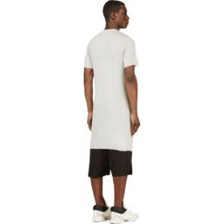

**Actual Caption**: Overlong semi-sheer jersey t-shirt in light grey. Crewneck collar. Raw edges at short sleeves and hem. Accent seam at back. Tonal stitching.
**Predicted Caption**: Short sleeve oversize t-shirt in ivory. Ribbed crewneck collar. Tonal stitching.


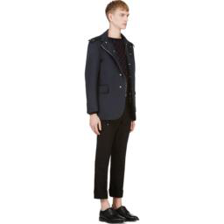

**Actual Caption**: Long sleeve wool sweater in navy. Anchor pattern embroidered in red throughout. Ribbed knit crewneck collar, sleeve cuffs, and hem. Signature tri-color tab at back collar. Two-button placket at sleeve cuffs and side seams. Tonal stitching.
**Predicted Caption**: Long sleeve blazer in grey. Subtle crosshatching effect throughout weave. Notched lapel collar. Two-button closure and flap pockets at front. Breast pocket. Four decorative buttons at sleeve cuffs. Vented at back. Welt pockets at interior. Fully lined. Tonal stitching.


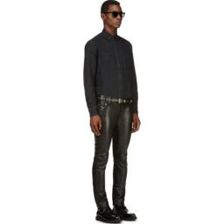

**Actual Caption**: Long sleeve denim shirt in washed black. Spread collar. Button closure and patch pockets at front. Single-button barrel cuffs. Tonal stitching.
**Predicted Caption**: Skinny-fit jeans in grey. Fading throughout. Seven-pocket styling. Signature ribbed panels at knees. Zippered ankle cuffs. Tonal stitching. Zip-fly.


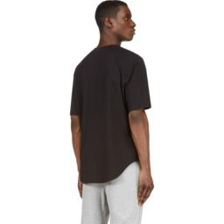

**Actual Caption**: Short sleeve relaxed-fit t-shirt in black. Crewneck collar. Curved shirttail hem. Tonal stitching.
**Predicted Caption**: Short sleeve relaxed-fit t-shirt in charcoal grey. Ribbed crewneck collar. Tonal stitching.


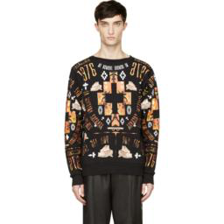

**Actual Caption**: Long sleeve sweatshirt in black. Crewneck collar. Mixed graphic and text prints throughout in tones of orange, yellow, and brown. Fleecy interior. Tonal stitching.
**Predicted Caption**: Long sleeve sweatshirt in grey. Patterned throughout in tones of white, brown, blue and yellow. Ribbed crewneck collar, cuffs, and hem. Fleecy interior. Tonal stitching.


In [33]:
import os
import random
import pandas as pd
from PIL import Image
from torchvision.transforms import functional as F
import torch


model = VisionEncoderDecoderModel.from_pretrained(model_output_dir)

tokenizer = AutoTokenizer.from_pretrained(model_output_dir)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

max_length = 64
num_beams = 4
gen_kwargs = {
    "max_length": max_length,
    "num_beams": num_beams,
    # "num_return_sequences": 3,
}



def load_random_image_and_caption(image_dir, captions_file):
    
    captions_df = pd.read_csv(captions_file)
    captions_df = captions_df.iloc[:5000]

    if 'image' not in captions_df.columns:
        print("Column 'image' not found in the CSV file.")
        return None, None


    random_row = captions_df.sample(n=1)
    random_image_name = random_row['image'].values[0]

    image_path = os.path.join(image_dir, random_image_name)

    if not os.path.isfile(image_path):
        print(f"Image file not found: {image_path}")
        return None, None

    if 'caption' in captions_df.columns:
        actual_caption = random_row['caption'].values[0]
    else:
        actual_caption = None

    return image_path, actual_caption

def predict_step(image_dir, captions_file):

    image_path, actual_caption = load_random_image_and_caption(image_dir, captions_file)

    if image_path is None or actual_caption is None:
        return

    i_image = Image.open(image_path)
    if i_image.mode != "RGB":
        i_image = i_image.convert(mode="RGB")
    i_image = i_image.resize((224, 224))

    display(i_image)

    image_tensor = F.to_tensor(i_image).unsqueeze(0)
    image_tensor = image_tensor.to(device)

    output_ids = model.generate(image_tensor, **gen_kwargs)

    pred = tokenizer.batch_decode(output_ids, skip_special_tokens=True)[0].strip()

    print(f"**Actual Caption**: {actual_caption}")
    print(f"**Predicted Caption**: {pred}")

    
image_directory = 'fashion/FashionGen/images_val'
captions_csv_file = 'fashion/FashionGen/FashionGen_val.csv'
predict_step(image_directory, captions_csv_file)
predict_step(image_directory, captions_csv_file)
predict_step(image_directory, captions_csv_file)
predict_step(image_directory, captions_csv_file)
predict_step(image_directory, captions_csv_file)